In [41]:
import torch

torch.__version__

'2.0.1+cu118'

In [42]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
from pathlib import Path

# Setting up dataset path
data_path = Path('data')

import os

for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

There are 3 directories and 0 images in data 
There are 2 directories and 0 images in data/val 
There are 0 directories and 11 images in data/val/present 
There are 0 directories and 17 images in data/val/missing 
There are 2 directories and 0 images in data/test 
There are 0 directories and 6 images in data/test/present 
There are 0 directories and 10 images in data/test/missing 
There are 2 directories and 0 images in data/train 
There are 0 directories and 39 images in data/train/present 
There are 0 directories and 62 images in data/train/missing 


In [44]:
# Setup train val data
train_dir = data_path / 'train'
val_dir = data_path / 'val'
test_dir = data_path / 'test'

train_dir, val_dir, test_dir

(PosixPath('data/train'), PosixPath('data/val'), PosixPath('data/test'))

(-0.5, 407.5, 378.5, -0.5)

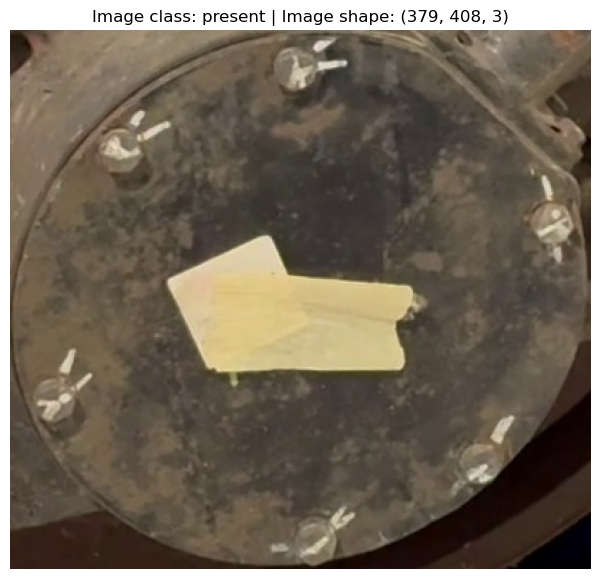

In [45]:
# Visualize the dataset
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Random seed
# random.seed(42)

# Get all images from datapath
image_path_list = list(data_path.glob("*/*/*.jpg"))

# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class
image_class = random_image_path.parent.stem

# Opening the image
rand_img = Image.open(random_image_path)

# Converting the image as numpy array
rand_img_as_array = np.asarray(rand_img)

# Plotting
plt.figure(figsize=(12,7))
plt.imshow(rand_img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {rand_img_as_array.shape}")
plt.axis(False)


In [46]:
# Transform the data
from torch.utils.data import DataLoader
from torchvision import transforms

# Data augmentation we will do
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 90)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
])

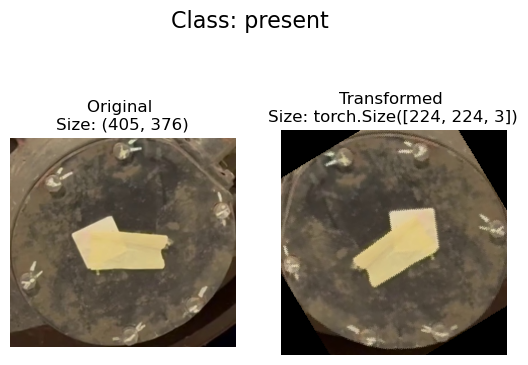

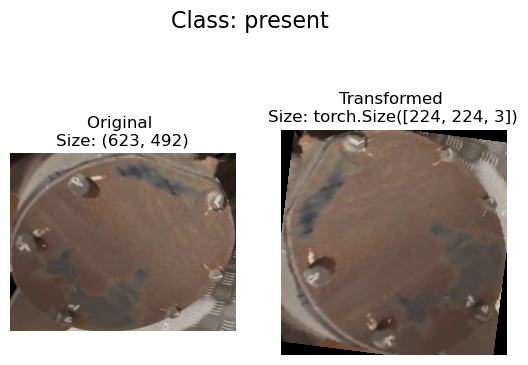

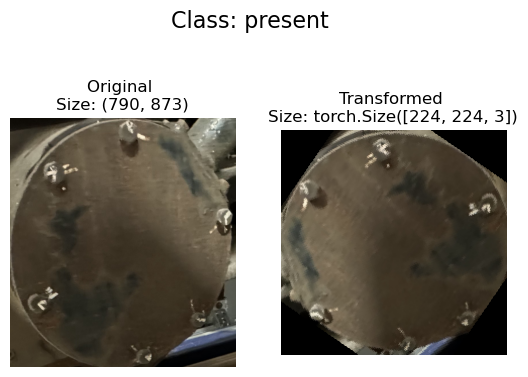

In [47]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image, cmap='gray') 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [48]:
# Import dataset
from torchvision import datasets

# Implementing test transforms with basic augmentation
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_data, val_data, test_data

(Dataset ImageFolder
     Number of datapoints: 101
     Root location: data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomRotation(degrees=[0.0, 90.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 28
     Root location: data/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomRotation(degrees=[0.0, 90.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 16
     Root location: data/test
     StandardTransform
 Tran

In [49]:
class_names = train_data.classes
class_names

['missing', 'present']

In [50]:
class_name_map = train_data.class_to_idx
class_name_map

{'missing': 0, 'present': 1}

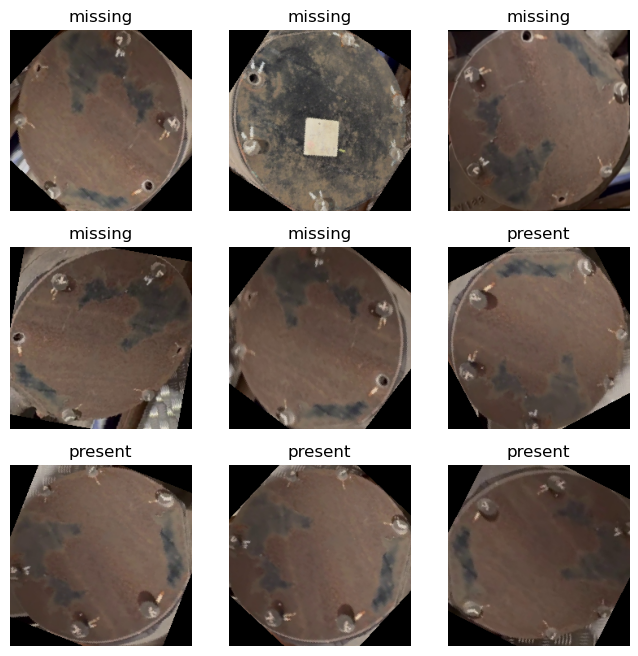

In [51]:
labels_map = {
    0: "missing",
    1: "present",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(img.squeeze().permute(1,2,0))
plt.show()

In [52]:
# Turning Dataset into dataloaders
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [53]:
import torch.nn as nn
import torch.nn.functional as F

In [54]:
class ProjectorBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProjectorBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features,
            kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        return self.op(x)


class SpatialAttn(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(SpatialAttn, self).__init__()
        self.normalize_attn = normalize_attn
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1,
            kernel_size=1, padding=0, bias=False)

    def forward(self, l, g):
        N, C, H, W = l.size()
        c = self.op(l+g) # (batch_size,1,H,W)
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,H,W)
        else:
            a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        if self.normalize_attn:
            g = g.view(N,C,-1).sum(dim=2) # (batch_size,C)
        else:
            g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)
        return c.view(N,1,H,W), g

In [55]:
class AttnVGG(nn.Module):
    def __init__(self, sample_size, num_classes, attention=True, normalize_attn=True, init_weights=True):
        super(AttnVGG, self).__init__()
        # conv blocks
        self.conv1 = self._make_layer(3, 64, 2)
        self.conv2 = self._make_layer(64, 128, 2)
        self.conv3 = self._make_layer(128, 256, 3)
        self.conv4 = self._make_layer(256, 512, 3)
        self.conv5 = self._make_layer(512, 512, 3)
        self.conv6 = self._make_layer(512, 512, 2, pool=True)
        self.dense = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=int(sample_size/32), padding=0, bias=True)
        # attention blocks
        self.attention = attention
        if self.attention:
            self.projector = ProjectorBlock(256, 512)
            self.attn1 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
            self.attn2 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
            self.attn3 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
        # final classification layer
        if self.attention:
            self.classify = nn.Linear(in_features=512*3, out_features=num_classes, bias=True)
        else:
            self.classify = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        # if init_weights:
        #     self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        l1 = self.conv3(x)
        x = F.max_pool2d(l1, kernel_size=2, stride=2, padding=0)
        l2 = self.conv4(x)
        x = F.max_pool2d(l2, kernel_size=2, stride=2, padding=0)
        l3 = self.conv5(x)
        x = F.max_pool2d(l3, kernel_size=2, stride=2, padding=0)
        x = self.conv6(x)
        g = self.dense(x) # batch_sizex512x1x1
        # attention
        if self.attention:
            c1, g1 = self.attn1(self.projector(l1), g)
            c2, g2 = self.attn2(l2, g)
            c3, g3 = self.attn3(l3, g)
            g = torch.cat((g1,g2,g3), dim=1) # batch_sizex3C
            # classification layer
            x = self.classify(g) # batch_sizexnum_classes
        else:
            c1, c2, c3 = None, None, None
            x = self.classify(torch.squeeze(g))
        return [x, c1, c2, c3]

    def _make_layer(self, in_features, out_features, blocks, pool=False):
        layers = []
        for i in range(blocks):
            conv2d = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1, bias=False)
            layers += [conv2d, nn.BatchNorm2d(out_features), nn.ReLU(inplace=True)]
            in_features = out_features
            if pool:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [56]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        if isinstance(y_pred, list):
            y_pred = y_pred[0]
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()



        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [57]:
def val_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup val loss and val accuracy values
    val_loss, val_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            val_pred_logits = model(X)
            if isinstance(val_pred_logits, list):
                val_pred_logits = val_pred_logits[0]
            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            
            val_loss += loss.item()
            
            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [58]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [59]:
from tqdm.auto import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# 1. Take in various parameters required for training and val steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    early_stopper = EarlyStopper(patience=10, min_delta=0.02)

    # 3. Loop through training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        scheduler.step()
        val_loss, val_acc = val_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)

        if early_stopper.early_stop(val_loss):             
            break
    
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [60]:
import torch.optim.lr_scheduler as lr_scheduler

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
model = AttnVGG(sample_size=224, num_classes=2).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) #
lr_lambda = lambda epoch : np.power(0.5, int(NUM_EPOCHS/25))
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8654 | train_acc: 0.6154 | val_loss: 1.1216 | val_acc: 0.3929
Epoch: 2 | train_loss: 0.5868 | train_acc: 0.7404 | val_loss: 0.7093 | val_acc: 0.5714
Epoch: 3 | train_loss: 0.6162 | train_acc: 0.7212 | val_loss: 0.6084 | val_acc: 0.7143
Epoch: 4 | train_loss: 0.6315 | train_acc: 0.6154 | val_loss: 0.5870 | val_acc: 0.7500
Epoch: 5 | train_loss: 0.6144 | train_acc: 0.6250 | val_loss: 0.5915 | val_acc: 0.6071
Epoch: 6 | train_loss: 0.6186 | train_acc: 0.7212 | val_loss: 2.0271 | val_acc: 0.3929
Epoch: 7 | train_loss: 0.6635 | train_acc: 0.6827 | val_loss: 0.7092 | val_acc: 0.6071
Epoch: 8 | train_loss: 0.6250 | train_acc: 0.6346 | val_loss: 0.5533 | val_acc: 0.7857
Epoch: 9 | train_loss: 0.6447 | train_acc: 0.5962 | val_loss: 0.6358 | val_acc: 0.6071
Epoch: 10 | train_loss: 0.5932 | train_acc: 0.6731 | val_loss: 0.5755 | val_acc: 0.7857
Epoch: 11 | train_loss: 0.6358 | train_acc: 0.6827 | val_loss: 0.5501 | val_acc: 0.7857
Epoch: 12 | train_loss: 0.5925 | train_ac

In [61]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["val_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["val_loss"]
    epochs=range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

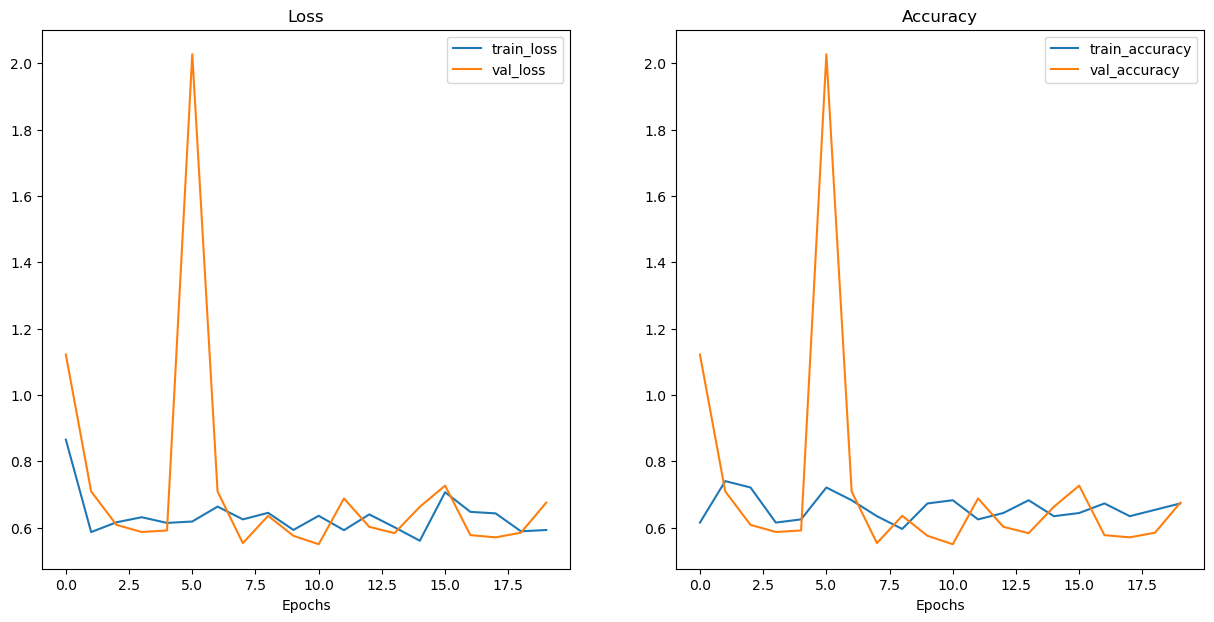

In [62]:
plot_loss_curves(model_0_results)

In [63]:
torch.save(model.state_dict(), "attention_cnn_epoch.pth")

In [64]:
import cv2
def visualize_attn(I, c):
    # Image
    img = I.permute((1,2,0)).cpu().numpy()
    # Heatmap
    N, C, H, W = c.size()
    a = F.softmax(c.view(N,C,-1), dim=2).view(N,C,H,W)
    up_factor = 224/H
    # print(up_factor, I.size(), c.size())
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=4, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    # Add the heatmap to the image
    vis = 0.6 * img + 0.4 * attn
    return vis

In [65]:
import torchvision.utils as utils
from torchvision.utils import save_image
model.load_state_dict(torch.load("attention_cnn_epoch.pth"))
model.eval()

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_dataloader):
        # get images
        inputs = inputs.to(device)
        if batch_idx == 0:
            images = inputs[0:16,:,:,:]
            I = utils.make_grid(images, nrow=4, normalize=True, scale_each=True)
            save_image(I,'origin.jpg')
            _, c1, c2, c3 = model(images)
            # print(I.shape, c1.shape, c2.shape, c3.shape, c4.shape)
            attn1 = visualize_attn(I, c1)
            cv2.imwrite('attn1.jpg', attn1)
            attn2 = visualize_attn(I, c2)
            cv2.imwrite('attn2.jpg', attn2)
            attn3 = visualize_attn(I, c3)
            cv2.imwrite('attn3.jpg', attn3)
            break

In [68]:
import torchvision.utils as utils
from torchvision.utils import save_image
# Recreate an instance of TinyVGG
model = AttnVGG(sample_size=224, num_classes=2).to(device)
model.load_state_dict(torch.load("attention_cnn_epoch.pth"))
model.eval()
y_preds = []
val_loss = 0
val_acc = 0
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    if isinstance(y_logit, list):
      y_logit = y_logit[0]
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    
    loss = loss_fn(y_logit, y)
            
    val_loss += loss.item()
    
    val_acc += ((y_pred == y).sum().item()/len(y_pred))
    
  val_loss /= len(test_dataloader)
  val_acc /= len(test_dataloader)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

print(f"Test Acc {val_acc:.4f} | Test Loss {val_loss:.4f}")

Making predictions:   0%|          | 0/4 [00:01<?, ?it/s]

Test Acc 0.6250 | Test Loss 0.5846


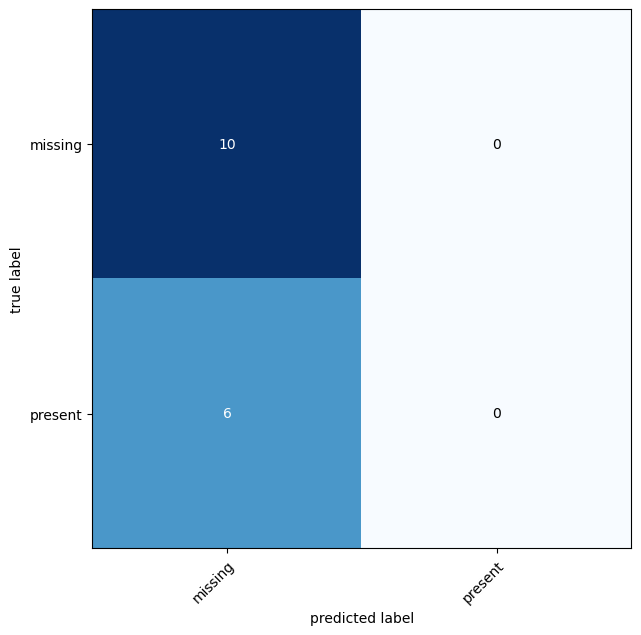

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='binary')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
torch.tensor(test_data.targets)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])